# Train model

In [23]:
import os
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import hayai_util

portfolio_id = 'medium_tech_usa'
portfolio_id = 'ETF1'
#label_column = 'target'

context = hayai_util.create_context(portfolio_id)

## Step 1: build the dataset

In [ ]:
filename = os.path.join(context['portfolio_dir'], "features.parquet")
df = pd.read_parquet(filename)
# unisci le righe di tutti i dataframe in uno solo
df = df.dropna()
df.shape

(53579, 15)

## EDA

In [25]:
df.describe()

,log_return,mom_5,mom_10,mom_rank,vol_10,vol_20,vol_ratio,zscore_20,trend_50,volume_zscore,volume_shock,vol_regime,target
count,53579.000000,53579.000000,53579.000000,53579.000000,53579.000000,53579.000000,53579.000000,53579.000000,53579.000000,53579.000000,53579.000000,53579.000000,53579.000000
mean,-0.000304,-0.000042,-0.000142,-0.000048,0.011354,0.013169,0.885148,-0.025501,-0.001378,0.023583,1.023974,0.967730,-0.091576
std,0.024251,0.020854,0.029176,0.989260,0.015987,0.017466,0.246721,1.305399,0.038961,1.012081,1.066847,0.281851,2.308943
min,-1.094630,-0.665337,-0.666670,-6.638256,0.000538,0.000718,0.008356,-4.244712,-0.657308,-2.910958,0.000000,0.004090,-143.232607
25%,-0.007562,-0.007534,-0.011058,-0.417562,0.005208,0.006242,0.711601,-1.112719,-0.015045,-0.574220,0.543762,0.778965,-0.805389
50%,-0.000047,-0.000047,-0.000217,-0.054298,0.008259,0.009788,0.891660,-0.036657,-0.000834,-0.273479,0.808063,0.942644,0.000000
75%,0.007512,0.007540,0.010828,0.336458,0.013771,0.015728,1.071769,1.079868,0.013145,0.305937,1.162046,1.130291,0.765453
max,0.238570,0.269433,0.285181,6.167443,0.576744,0.483887,1.444736,3.626231,0.275824,4.248216,19.422865,2.460061,8.344127


In [26]:
df = df.drop(columns=['date', 'symbol'])
df.info()

<class 'pandas.DataFrame'>
Index: 53579 entries, 60 to 56582
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   log_return     53579 non-null  float64
 1   mom_5          53579 non-null  float64
 2   mom_10         53579 non-null  float64
 3   mom_rank       53579 non-null  float64
 4   vol_10         53579 non-null  float64
 5   vol_20         53579 non-null  float64
 6   vol_ratio      53579 non-null  float64
 7   zscore_20      53579 non-null  float64
 8   trend_50       53579 non-null  float64
 9   volume_zscore  53579 non-null  float64
 10  volume_shock   53579 non-null  float64
 11  vol_regime     53579 non-null  float64
 12  target         53579 non-null  float64
dtypes: float64(13)
memory usage: 5.7 MB


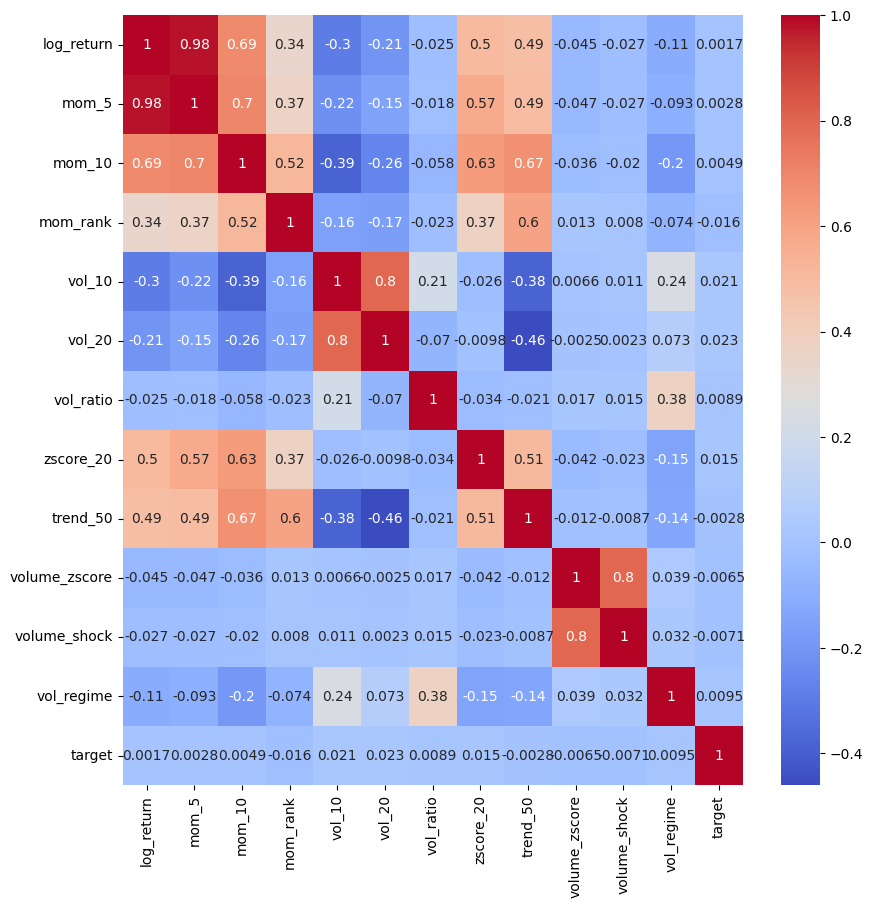

In [27]:
# display the correlation map using seaborn
plt.figure(figsize=(10, 10))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

## Normalize

In [28]:
maxs = df.max()
mins = df.min()
df = (df - mins) / (maxs - mins)
label_min = mins[label_column]
label_max = maxs[label_column]
hayai_util.save_normalization_params(label_min, label_max)

True

## Model building

In [29]:
labels = df[label_column].values
df = df.drop(columns=[label_column])
data = df.values


In [30]:
from keras.models import Sequential
from keras.layers import Input, Dense,Conv1D,Conv2D,Flatten,MaxPool2D,BatchNormalization,MaxPooling1D
from keras.optimizers import Adam, SGD
from sklearn.model_selection import train_test_split
print("Labels Shape: %s" % (labels.shape,))
print("Data Shape: %s" % (data.shape,))
X, X_test, Y, Y_test = train_test_split(data, labels, test_size=0.2, random_state=1,shuffle=True)
print("Train Data Shape: %s" % (X.shape,))
print("Train Labels Shape: %s" % (Y.shape,))
print("Test Data Shape: %s" % (X_test.shape,))
print("Test Labels Shape: %s" % (Y_test.shape,))

Labels Shape: (53579,)
Data Shape: (53579, 12)
Train Data Shape: (42863, 12)
Train Labels Shape: (42863,)
Test Data Shape: (10716, 12)
Test Labels Shape: (10716,)


In [31]:
n_row = data.shape[1]
channels = 1 # non ci sono colori, il channel è 1 (usato solo in Conv2D)
batch_size = 64

model = Sequential()
model.add(Input(shape=(n_row,), name='input_layer'))
model.add(Dense(32, activation='relu',name='layerDense1'))
model.add(Dense(16, activation='relu',name='layerDense2'))
model.add(Dense(8, activation='relu',name='layerDense3'))
model.add(Dense(1,activation='sigmoid',name='output_layer'))
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ layerDense1 (Dense)             │ (None, 32)             │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layerDense2 (Dense)             │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layerDense3 (Dense)             │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,089 (4.25 KB)

 Trainable params: 1,089 (4.25 KB)

 Non-trainable params: 0 (0.00 B)

In [32]:
# questa è la funzione di costo
optimizer = Adam(learning_rate=context['learning_rate'])
model.compile(loss='mean_squared_error', optimizer=optimizer)
#model.compile(loss='mean_squared_error', optimizer='SGD')

# questo è il training
model.fit(
    X,
    Y,
    epochs=context['epochs'],
    shuffle=True,
    verbose=2,
    batch_size=context['batch_size'],
    validation_split=context['validation_split']
)
# il modello è pronto, applichiamo il modello al dataset di test

results = model.evaluate(X_test, Y_test, verbose=2,)
print("Test loss: %f" % results)
filename = os.path.join(context['portfolio_dir'], 'model_summary.txt')
with open(filename, 'w',encoding='utf-8') as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))
model.save(os.path.join(context['portfolio_dir'], 'model.keras'))
print("Model saved to: %s" % os.path.join(context['portfolio_dir'], 'model.keras'))

Epoch 1/20
536/536 - 1s - 2ms/step - loss: 0.0046 - val_loss: 2.0118e-04
Epoch 2/20
536/536 - 1s - 1ms/step - loss: 2.2556e-04 - val_loss: 1.9546e-04
Epoch 3/20
536/536 - 1s - 1ms/step - loss: 2.2164e-04 - val_loss: 1.9505e-04
Epoch 4/20
536/536 - 1s - 1ms/step - loss: 2.2056e-04 - val_loss: 1.9355e-04
Epoch 5/20
536/536 - 1s - 1ms/step - loss: 2.2017e-04 - val_loss: 1.9285e-04
Epoch 6/20
536/536 - 1s - 1ms/step - loss: 2.2005e-04 - val_loss: 1.9370e-04
Epoch 7/20
536/536 - 1s - 1ms/step - loss: 2.2058e-04 - val_loss: 1.9240e-04
Epoch 8/20
536/536 - 1s - 2ms/step - loss: 2.2001e-04 - val_loss: 1.9219e-04
Epoch 9/20
536/536 - 1s - 1ms/step - loss: 2.1993e-04 - val_loss: 1.9219e-04
Epoch 10/20
536/536 - 1s - 1ms/step - loss: 2.2031e-04 - val_loss: 1.9306e-04
Epoch 11/20
536/536 - 1s - 1ms/step - loss: 2.1940e-04 - val_loss: 2.0066e-04
Epoch 12/20
536/536 - 1s - 1ms/step - loss: 2.1988e-04 - val_loss: 1.9294e-04
Epoch 13/20
536/536 - 1s - 1ms/step - loss: 2.1973e-04 - val_loss: 1.9181e-04

Model saved to: data\ETF1\model.keras


In [33]:
tp = 0
tn = 0
fp = 0
fn = 0
print(label_min, label_max, label_max - label_min)
#denormalize labels
labels = Y_test * (label_max - label_min) + label_min
predictions = model.predict(X_test, verbose=0)
errors = []
for i in range(len(X_test)):
    p = predictions[i][0]
    label = labels[i]
    p = p * (label_max - label_min) + label_min # denormalize prediction
    if i < 30:
        print(f"Label: {label:.4f}, Prediction: {p:.4f}")
    errors.append((label - p))
    if label > 0 and p > 0:
        tp += 1
    elif label <= 0 and p <= 0:
        tn += 1
    elif label <= 0 and p > 0:
        fp += 1
    elif label > 0 and p <= 0:
        fn += 1
eqm = math.sqrt(sum([e**2 for e in errors])/len(errors))
print(f"Mean Squared Error: {eqm:.4f}")
print("True Positives: %d, True Negatives: %d, False Positives: %d, False Negatives: %d" % (tp, tn, fp, fn))
print("positive labels: %d, negative labels: %d" % (sum(labels > 0), sum(labels <= 0)))
print("Sum true",tp+tn, "Sum false",fp+fn)
print("Precision: %.4f" % (tp / (tp + fp) if (tp + fp) > 0 else 0))
print("Recall: %.4f" % (tp / (tp + fn) if (tp + fn) > 0 else 0))
print("Accuracy: %.4f" % ((tp + tn) / len(X_test) if len(X_test) > 0 else 0))

-143.23260669633376 8.344126867021528 151.57673356335528
Label: -0.1336, Prediction: -0.6846
Label: -0.2354, Prediction: -0.1141
Label: 2.0162, Prediction: -0.1762
Label: -0.7341, Prediction: -0.7056
Label: 1.4220, Prediction: -0.6885
Label: 0.6969, Prediction: -0.2143
Label: -0.8836, Prediction: -0.3774
Label: 0.0197, Prediction: 0.2053
Label: 0.1668, Prediction: -0.0789
Label: -1.1611, Prediction: -0.1005
Label: 0.1843, Prediction: 0.7614
Label: -0.1325, Prediction: -0.1447
Label: 0.2471, Prediction: -0.0589
Label: -0.1488, Prediction: -0.2747
Label: -0.9903, Prediction: -0.1358
Label: 0.8375, Prediction: -0.2542
Label: 0.8907, Prediction: -0.1772
Label: -0.2706, Prediction: -0.2668
Label: -1.9689, Prediction: -0.5939
Label: 1.3985, Prediction: -0.3126
Label: -1.7171, Prediction: -0.1765
Label: -3.4348, Prediction: -0.0827
Label: 0.3844, Prediction: -0.2172
Label: 1.2467, Prediction: -0.1346
Label: -0.8712, Prediction: 0.2009
Label: 0.2766, Prediction: -0.2103
Label: 0.5835, Predicti